# Deduplication Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed  # force n2 import to avoid libgomp issue https://github.com/kakao/n2/issues/42

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Music Brainz 20K from Database Group Leipzig](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). From the site: "The Music Brainz dataset is based on real records about songs from the MusicBrainz database but uses the DAPO data generator to create duplicates with modified attribute values. The generated dataset consists of five sources and contains duplicates for 50% of the original records in two to five sources. All duplicates are generated with a high degree of corruption to stress-test the ER and clustering approaches."

Here is it's [README](https://www.informatik.uni-leipzig.de/~saeedi/musicBrainz_readme.txt):

```
5 sources
---------- 
TID: a unique record's id (in the complete dataset).
CID: cluster id (records having the same CID are duplicate)
CTID: a unique id within a cluster (if two records belong to the same cluster they will have the same CID but different CTIDs). These ids (CTID) start with 1 and grow until cluster size.
SourceID: identifies to which source a record belongs (there are five sources). The sources are deduplicated.
Id: the original id from the source. Each source has its own Id-Format. Uniqueness is not guaranteed!! (can be ignored).
number: track or song number in the album.
length: the length of the track.
artist: the interpreter (artist or band) of the track.
year: date of publication.
language: language of the track.
```

Let's download the CSV dataset to a temporary directory:

In [6]:
import urllib
import tempfile

dataset_url = 'https://www.informatik.uni-leipzig.de/~saeedi/musicbrainz-20-A01.csv.dapo'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Now we must read the CSV dataset into a `dict` called `row_dict`.

`row_dict` will contain all rows from the dataset, and each row will have the indication of the true cluster it belongs to in the attr `CID`.

So `CID` is our `cluster_attr`. entity-embed needs that to train, validate, and test.

We'll dynamically attribute an ID for each row using `enumerate`. entity-embed needs that too.

In [7]:
import csv

row_dict = {}
cluster_attr = 'CID'

with open(tf.name, newline='') as f:
    for current_row_id, row in enumerate(csv.DictReader(f)):
        row['id'] = current_row_id
        row[cluster_attr] = int(row[cluster_attr])  # convert cluster_attr to int
        row_dict[current_row_id] = row

Here's an example of a row:

In [8]:
row_dict[83]

{'TID': '84',
 'CID': 9369,
 'CTID': '4',
 'SourceID': '4',
 'id': 83,
 'number': '1',
 'title': '001-Berimbou',
 'length': '2m 23sec',
 'artist': 'Astrud Gilberto',
 'album': 'Look to the Rainbow (2008)',
 'year': 'null',
 'language': ' Eng.'}

That's a great song, but it's actually called "Berimbau", not "Berimbou"! And it's a Brazilian song, in Portuguese. This a small example on how noisy is this dataset...

## Preprocessing

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, and strip leading and trailing whitespace.

The fields we'll clean are the ones we'll use:

In [9]:
attr_list = ['number', 'title', 'artist', 'album', 'year', 'language']

In [10]:
import unidecode

def clean_str(s):
    return unidecode.unidecode(s).lower().strip()

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

In [11]:
{k: v for k, v in row_dict[83].items() if k in attr_list}

{'number': '1',
 'title': '001-berimbou',
 'artist': 'astrud gilberto',
 'album': 'look to the rainbow (2008)',
 'year': 'null',
 'language': 'eng.'}

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

It's worth noting you can use any alphabet you need, so this accent removal is optional.

## Configure entity-embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [12]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

Then we set an `attr_config_dict`. It defines types, which determine how attributes are processed in the neural network:

In [13]:
attr_config_dict = {
    'number': {
        'field_type': "STRING",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'title': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'use_mask': True,
        'max_str_len': None,  # compute
    },
    'title_semantic': {
        'source_attr': 'title',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'artist': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'use_mask': True,
        'max_str_len': None,  # compute
    },
    'album': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'use_mask': True,
        'max_str_len': None,  # compute
    },
    'album_semantic': {
        'source_attr': 'album',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'year': {
        'field_type': "STRING",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'language': {
        'field_type': "STRING",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
}

Then we use our `attr_config_dict` to get a `row_numericalizer`.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Also, one must keep this `row_numericalizer` to use on production data:

In [14]:
from entity_embed import AttrConfigDictParser

row_numericalizer = AttrConfigDictParser.from_dict(attr_config_dict, row_list=row_dict.values())
row_numericalizer

14:13:30 INFO:For attr=number, computing actual max_str_len
14:13:30 INFO:For attr=number, using actual_max_str_len=56
14:13:30 INFO:For attr=title, computing actual max_str_len
14:13:30 INFO:For attr=title, using actual_max_str_len=38
14:13:30 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
14:13:34 INFO:For attr=artist, computing actual max_str_len
14:13:34 INFO:actual_max_str_len=31 must be even to enable NN pooling. Updating to 32
14:13:34 INFO:For attr=artist, using actual_max_str_len=32
14:13:34 INFO:For attr=album, computing actual max_str_len
14:13:34 INFO:For attr=album, using actual_max_str_len=40
14:13:34 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
14:13:37 INFO:For attr=year, computing actual max_str_len
14:13:37 INFO:For attr=year, using actual_max_str_len=68
14:13:37 INFO:For attr=language, computing actual max_str_len
14:13:37 INFO:For attr=language, using actual_max_str_len=72


<RowNumericalizer with attr_config_dict={'number': AttrConfig(source_attr='number', field_type=<FieldType.STRING: 'string'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=56, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True), 'title': AttrConfig(source_attr='title', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '

## Initialize Data Module

Under the hoods entity-embed uses [pytorch-lightning](https://www.pytorchlightning.ai/), so we need to create a datamodule object to split our dataset between train, valid, and test data.

In [15]:
clusters_total = len(set(row[cluster_attr] for row in row_dict.values()))
clusters_total

10000

Since there's a lot of clusters, we'll use only 2000 for training, and other 2000 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for deduplication.

In [16]:
from entity_embed import DeduplicationDataModule

train_cluster_len = 2000
valid_cluster_len = 2000
batch_size = 20
eval_batch_size = 50
datamodule = DeduplicationDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    random_seed=random_seed
)

We've used `DeduplicationDataModule` because we're doing Deduplication of a single dataset/table (a.k.a. Entity Clustering, Entity Resolution, etc.).

We're NOT doing Record Linkage of two datasets here. Check the other notebook Record-Linkage-Example if you want to learn how to do it with entity-embed.

## Training

Now the training process! Thanks to pytorch-lightining, it's easy to train, validate, and test with the same datamodule.

We must choose the approximate nearest neighbors K, i.e., the top N our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [17]:
from entity_embed import EntityEmbed

ann_k = 100
model = EntityEmbed(
    row_numericalizer,
    ann_k=ann_k,
)

Inspecting the model will reveal it's built based on the attributes we set on `attr_config_dict`: 

In [18]:
model

EntityEmbed(
  (blocker_net): BlockerNet(
    (embedding_net_dict): ModuleDict(
      (number): StringEmbedCNN(
        (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (dense_net): Sequential(
          (0): Linear(in_features=15456, out_features=300, bias=True)
          (1): Dropout(p=0.2, inplace=False)
        )
      )
      (title): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (dense_net): Sequential(
            (0): Linear(in_features=10488, out_features=300, bias=True)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (title_semantic): MultitokenAttentionEmbed(
        (embedding_net): SemanticEmbedNet(
          (dense_net): Sequential(
            (0): Embedding(20725, 300)
   

To train, we use a [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/1.1.6/trainer.html).

To strike a balance between precision and recall, we'll use the metric `valid_f1_at_0.5` for early stopping.

`0.5` here is the threshold for cosine similarity of embedding vectors. Note we're using a validation metric, as the training process will run validation on every epoch due to `check_val_every_n_epoch=1`.

We also set a `TensorBoardLogger`, thus you can use `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics.

In [19]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_f1_at_0.5',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_save_dir = 'tb_logs'
tb_name = 'music'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_save_dir, name=tb_name),
    reload_dataloaders_every_epoch=True
)

GPU available: True, used: True
14:13:38 INFO:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
14:13:38 INFO:TPU available: None, using: 0 TPU cores


OK, all set, call `fit`!

In [20]:
trainer.fit(model, datamodule)

14:13:38 INFO:Train pair count: 3267
14:13:38 INFO:Valid pair count: 3358
14:13:38 INFO:Test pair count: 9625
14:13:38 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 37.1 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
27.4 M    Trainable params
9.8 M     Non-trainable params
37.1 M    Total params
148.526   Total estimated model params size (MB)
14:15:12 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 37.1 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
27.4 M    Trainable params
9.8 M     Non-trainable params
37.1 M    Total params
148.526   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Now training is done, we can easily check which attributes are most important for the final embedding:

In [21]:
model.blocker_net.get_signature_weights()

{'number': 0.08677787333726883,
 'title': 0.2215711772441864,
 'title_semantic': 0.18646948039531708,
 'artist': 0.10041037201881409,
 'album': 0.16213704645633698,
 'album_semantic': 0.16076743602752686,
 'year': 0.04587164521217346,
 'language': 0.03599495813250542}

And we can check the best validation model:

In [22]:
from entity_embed import validate_best

validate_best(trainer)

14:42:25 INFO:Validating best model...


{'valid_f1_at_0.5': 0.7191358024691359,
 'valid_f1_at_0.7': 0.9382192610539067,
 'valid_f1_at_0.9': 0.6484312148028961,
 'valid_pair_entity_ratio_at_0.5': 1.458769466428389,
 'valid_pair_entity_ratio_at_0.7': 0.8286954301761552,
 'valid_pair_entity_ratio_at_0.9': 0.41205003829461323,
 'valid_precision_at_0.5': 0.5708785439271964,
 'valid_precision_at_0.7': 0.9544054220579175,
 'valid_precision_at_0.9': 0.9987608426270136,
 'valid_recall_at_0.5': 0.9714115544967242,
 'valid_recall_at_0.7': 0.9225729600952948,
 'valid_recall_at_0.9': 0.4800476474091721}

## Testing

With the best validation model (`ckpt_path='best'`), we can check the performance on the test set: 

In [23]:
trainer.test(ckpt_path='best', verbose=False)

14:42:43 INFO:Train pair count: 3267
14:42:43 INFO:Valid pair count: 3358
14:42:43 INFO:Test pair count: 9625
14:42:43 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_f1_at_0.5': 0.4932723571862857,
  'test_f1_at_0.7': 0.9277961302501181,
  'test_f1_at_0.9': 0.6280344557556774,
  'test_pair_entity_ratio_at_0.5': 2.4383158986772715,
  'test_pair_entity_ratio_at_0.7': 0.8166335264113426,
  'test_pair_entity_ratio_at_0.9': 0.38229445837295756,
  'test_precision_at_0.5': 0.3308041412565594,
  'test_precision_at_0.7': 0.9365869150963371,
  'test_precision_at_0.9': 0.9975124378109452,
  'test_recall_at_0.5': 0.9693506493506493,
  'test_recall_at_0.7': 0.9191688311688312,
  'test_recall_at_0.9': 0.4582857142857143}]

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict` (without the `cluster_attr` filled, of course).

So let's simulate that by removing `cluster_attr` from the test_row_dict:

In [24]:
import copy

test_row_dict_with_cluster = datamodule.test_row_dict
test_row_dict = copy.deepcopy(test_row_dict_with_cluster)

for row in test_row_dict.values():
    del row[cluster_attr]

Keep the `test_true_pair_set` in a variable for evaluation:

In [25]:
test_true_pair_set = datamodule.test_true_pair_set

Before testing manually, do some cleanup:

In [26]:
import gc
del trainer
del datamodule
gc.collect()
torch.cuda.empty_cache()

Then call `predict`:

In [27]:
test_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/232 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_vector_dict` have the same length of `test_row_dict`:

In [28]:
assert len(test_vector_dict) == len(test_row_dict)

Now init an `ANNEntityIndex`, insert all embeddings from `test_vector_dict` on it, and build it:

In [29]:
%%time

from entity_embed import ANNEntityIndex

ann_index = ANNEntityIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(test_vector_dict)
ann_index.build()

CPU times: user 6.86 s, sys: 70.4 ms, total: 6.93 s
Wall time: 824 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [30]:
%%time
from entity_embed.data_utils import utils

sim_threshold = 0.5
__, found_cluster_dict = ann_index.search_clusters(
    k=ann_k,
    sim_threshold=sim_threshold
)
found_pair_set = utils.cluster_dict_to_id_pairs(
    found_cluster_dict,
)

CPU times: user 57.6 s, sys: 299 ms, total: 57.9 s
Wall time: 7.1 s


Let's check now the metrics of the found duplicate pairs:

In [31]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

612.4654620904297

In [32]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.001333495568001075, 0.9815064935064935)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [33]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

7074941

In [34]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

178

In [35]:
cos_similarity = lambda a, b: np.dot(a, b)

In [36]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(-0.16166033,
 {'TID': '284',
  'CID': 5987,
  'CTID': '4',
  'SourceID': '4',
  'id': 283,
  'number': 'b2',
  'title': "0b2-don't burn the fires",
  'length': '3m 52sec',
  'artist': 'dead moon',
  'album': 'live evil (1991)',
  'year': 'null',
  'language': 'eng.'},
 {'TID': '6100',
  'CID': 3175,
  'CTID': '1',
  'SourceID': '1',
  'id': 6099,
  'number': '004',
  'title': 'oh holy night (a classic fm christmas 2008)',
  'length': '04:24',
  'artist': 'jonathan ansell',
  'album': 'a classic fm christmas 2008',
  'year': '2008',
  'language': ''})

(-0.101991445,
 {'TID': '10712',
  'CID': 9018,
  'CTID': '4',
  'SourceID': '1',
  'id': 10711,
  'number': '007',
  'title': 'someone so young (nice dreams)',
  'length': '06:38',
  'artist': 'coke weed',
  'album': 'nice dreams',
  'year': '2012',
  'language': ''},
 {'TID': '11253',
  'CID': 7778,
  'CTID': '4',
  'SourceID': '5',
  'id': 11252,
  'number': '173',
  'title': 'st. james infirmary, part 2',
  'length': '204000',
  'artist': 'artie saw',
  'album': 'non stop music',
  'year': '2007',
  'language': 'english'})

(-0.06990252,
 {'TID': '11240',
  'CID': 5383,
  'CTID': '3',
  'SourceID': '1',
  'id': 11239,
  'number': '003',
  'title': 'concerto no. 4, bwv 1049: iii. presto (brandenburg concertos 4, 5 & 6 (musica antiqua koln feat. conductor: goebel))',
  'length': '04:20',
  'artist': 'johann sebastian bach',
  'album': 'brandenburg concertos 4, 5 & 6 (musica antiqua koln feat. conductor: goebel)',
  'year': '1995',
  'language': ''},
 {'TID': '17788',
  'CID': 9174,
  'CTID': '1',
  'SourceID': '2',
  'id': 17787,
  'number': '10',
  'title': 'camila - perderte de nuevo',
  'length': '182',
  'artist': '',
  'album': 'todo cambio',
  'year': '06',
  'language': 'spadnish'})

In [37]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.4428395,
 {'TID': '9648',
  'CID': 6673,
  'CTID': '2',
  'SourceID': '2',
  'id': 9647,
  'number': '20',
  'title': 'unk.',
  'length': '178',
  'artist': '',
  'album': 'el tango: pasion y emocion',
  'year': '07',
  'language': 'spanish'},
 {'TID': '12841',
  'CID': 6673,
  'CTID': '1',
  'SourceID': '1',
  'id': 12840,
  'number': '020',
  'title': 'muchachita callejera (el tango: pasion y emocion)',
  'length': '02:58',
  'artist': 'carlos vicente geroni flores',
  'album': 'el tango: pasion y emocion',
  'year': '2007',
  'language': ''})

(0.23687707,
 {'TID': '13445',
  'CID': 1011,
  'CTID': '3',
  'SourceID': '3',
  'id': 13444,
  'number': '6',
  'title': '',
  'length': '1.35',
  'artist': 'sunny day service',
  'album': '',
  'year': "'00",
  'language': 'japaneese'},
 {'TID': '15851',
  'CID': 1011,
  'CTID': '2',
  'SourceID': '2',
  'id': 15850,
  'number': '6',
  'title': 'sunny day service - interlude',
  'length': '81',
  'artist': '',
  'album': 'love album',
  'year': '00',
  'language': 'japanese'})

(0.2910486,
 {'TID': '895',
  'CID': 2198,
  'CTID': '2',
  'SourceID': '3',
  'id': 894,
  'number': '4',
  'title': 'the cn tower belongs to the dead (many ives version) - many lives - 49 mp',
  'length': '5.467',
  'artist': 'final fantasy',
  'album': '',
  'year': "'06",
  'language': 'english'},
 {'TID': '4240',
  'CID': 2198,
  'CTID': '1',
  'SourceID': '2',
  'id': 4239,
  'number': '4',
  'title': 'n.a.',
  'length': '328',
  'artist': '',
  'album': 'many lives - 49 mp',
  'year': '06',
  'language': 'english'})

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [38]:
vis_sample_size = 10

In [39]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_cluster_dict = row_dict_to_cluster_dict(test_row_dict_with_cluster, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [40]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [41]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=15, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

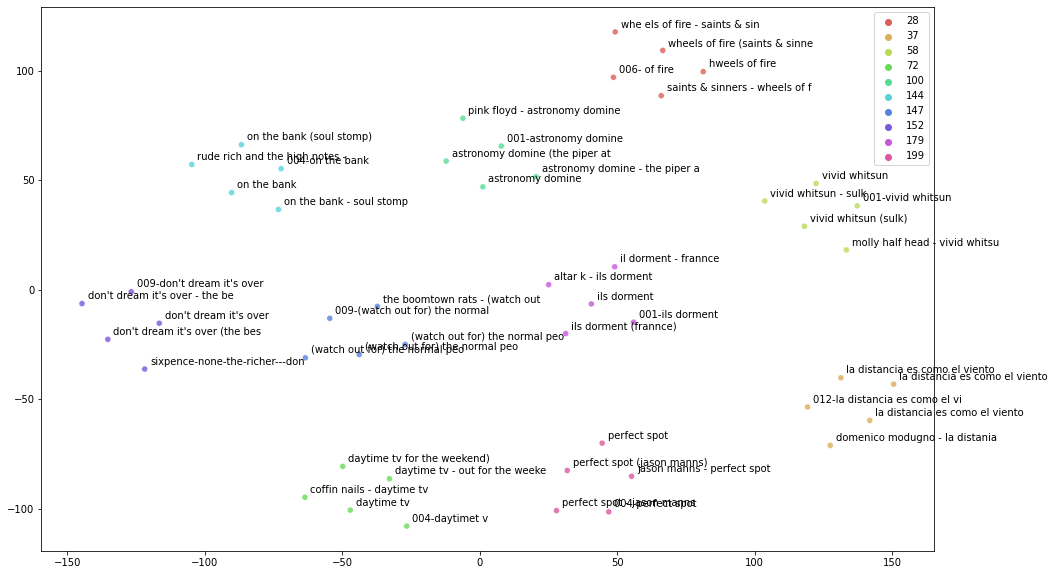

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['title'][:30]
    ax.text(x + 2, y + 2, text)